<a href="https://www.kaggle.com/code/dazhengzhu/nlp-with-disaster-tweets?scriptVersionId=194661528" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Natural Language Processing with Disaster Tweets 

## Introduction

This project is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. A dataset of 10,000 tweets that were hand classified is available.

Before we train a model on text data, we need to preprocess the text. In many cases, text needs to be **tokenized** and **vectorized** before it can be fed to a model, and in some cases the text requires additional preprocessing steps such as **normalization** and **feature selection**. After text is processed into a suitable format, we use it in natural language processing (NLP) workflow.

In this project we build two models for comparision: 
- Baseline model: The recurrent neural networks (RNN) are a class of neural networks that is powerful for modeling sequence data such as time series or natural language.
- SOTA model: The KerasNLP is a natural language processing library that supports workflows built from modular components that have state-of-the-art preset weights and architectures.

Finally, according to the performance of the model, we select the best model to make prediction.

### Key Takeaways

KerasNLP.DistilBERT model outperforms RNN model for disaster tweet classification, the findings include:

* **Higher Accuracy:** DistilBERT achieved a higher accuracy rate, indicating that it was more effective in correctly classifying disaster tweets.
* **Lower Loss:** The DistilBERT model exhibited a lower loss value, suggesting that it made fewer errors during training and testing.
* **Longer Training Time:** While DistilBERT required more time to train, its improved performance justified the increased computational cost.

### Setup

Set up Keras environment:

In [1]:
# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

# !pip install keras_core
# !pip install keras_nlp

Import Tensorflow, Keras and other necessary libearies:

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

Using TensorFlow backend
TensorFlow version: 2.16.1
KerasNLP version: 0.14.4


### Data

#### Preview the dataset

In [3]:
TRAINING_FILE_PATH = '../input/nlp-getting-started/train.csv'
TESTING_FILE_PATH = '../input/nlp-getting-started/test.csv'

df_train = pd.read_csv(TRAINING_FILE_PATH)
print(f'Training dataset:')
train_shape = df_train.shape
train_num_rows = train_shape[0]
print(f'Shape = {train_shape}')
print('Memory usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Head of data table:')
df_train.head()

Training dataset:
Shape = (7613, 5)
Memory usage = 0.29 MB
Head of data table:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Let's have a look at the train dataset.

- id: Tweet id in the table.
- keyword: A keyword from that tweet (may be blank)
- location: The location the tweet was sent from (may be blank)
- text: The text content of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [4]:
df_test = pd.read_csv(TESTING_FILE_PATH)
print(f'Testing dataset:')
test_shape = df_test.shape
# Save test rows for inference
test_num_rows = test_shape[0]
print(f'Shape = {test_shape}')
print('Memory usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))
print('Head of data table:')
df_test.head()

Testing dataset:
Shape = (3263, 4)
Memory usage = 0.10 MB
Head of data table:


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


We can see there are 7613 records for training, the `text` column contains the tweet content, and the corresponding label in the `target` column. Also, there're 3263 tweets for testing.

### Load dataset

We'll use the `tf.data.experimental.make_csv_dataset` to load the csv data, and shuffle the data and create batches of these data. Note that we set `num_epochs=1`, this ensure the dataset only goes through the data once, which making it finite, if this property was not been set, **the `vectorizer.adapt` process will be blocked.**

Then we use given validation split ratio `VALIDATION_SPILT` to split the main dataset to testing & validation subset.

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2

main_ds = tf.data.experimental.make_csv_dataset(
    TRAINING_FILE_PATH,
    select_columns=['text','target'],
    label_name='target',
    batch_size=BATCH_SIZE,
    num_epochs=1, # Ensure go through the data once to create a finite dataset
    shuffle=True,
    shuffle_buffer_size=BUFFER_SIZE,
    prefetch_buffer_size=tf.data.AUTOTUNE,
    num_rows_for_inference=train_num_rows # Help tf optimize the dataset creation
)

# Spilt the main dataset to train & validation datasets
num_val_elements = int(train_num_rows * VALIDATION_SPLIT // BATCH_SIZE)
raw_val_ds = main_ds.take(num_val_elements)
raw_train_ds = main_ds.skip(num_val_elements)

## Exploratory data analysis

### Preview the dataset spec

In [6]:
raw_train_ds.element_spec

(OrderedDict([('text',
               TensorSpec(shape=(None,), dtype=tf.string, name=None))]),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

We can see each element is a `(dict, label)` tuple, and the `dict` contains `text` data.

### Preview tweets

Let's preview first 3 tweets, notice the data order is shuffled:

In [7]:
for batch, label in raw_train_ds.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value[:3]}")
    print()
    print(f"{'label':20s}: {label[:3]}")

text                : [b'Ebola: Alabama Home Quarantined Over Possible Ebola Case.. Related Articles: http://t.co/BiigD1LEq3'
 b'Hey the #Royals love doing damage with 2 outs.'
 b'.@APHL responds: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/cGdj3dRso9']

label               : [1 1 1]


### Analysis Tweets

Before analysis tweets, we need to perform the text preprocessing, this step is to transform raw text data into a structured format suitable for analysis or modeling, by applying techniques like tokenization, stemming, stopwords removal, and normalization, we aim to facilitate analysis, reduce dimensionality, and enhance model performance.

In [8]:
def load_stopwords():
  nltk.download('punkt')
  nltk.download('stopwords')

load_stopwords()

# Function to preprocess text
def preprocess_text(text):
  # Tokenization
  words = nltk.word_tokenize(text=text, language='english')

  # Remove stop words
  stop_words = set(stopwords.words('english'))
  words = [word for word in words if word not in stop_words]

  # Stemming
  stemmer = PorterStemmer()
  words = [stemmer.stem(word) for word in words]

  return ' '.join(words)

# Apply preprocessing to the 'clean_text' column
df_train['clean_text'] = df_train['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Show tweets Word Cloud

(-0.5, 799.5, 399.5, -0.5)

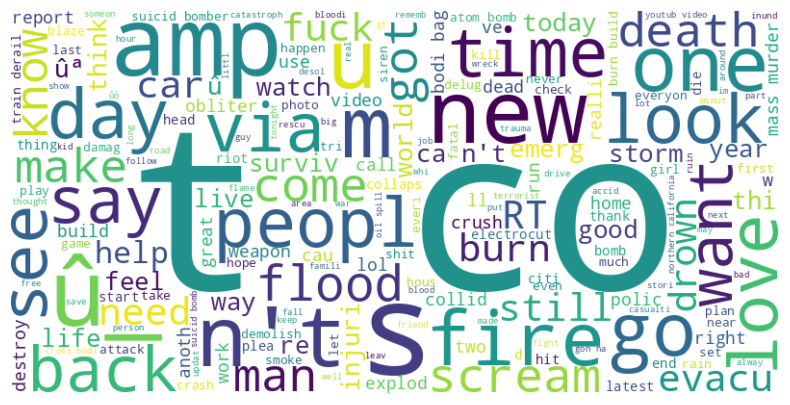

In [9]:
text = ' '.join(df_train['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

We could observe from the Word Could picture:

- High-frequency disaster words: words like "help", "death", "life", "people", "survive", "kill" are common used function words in English.
- Specific disaster: words like "flood", "drown", "fire", "storm", "bomb" are consider specific disaster.

#### Show tweets Word Frequency

In [10]:
def get_word_counts(text_data):
  all_words = []
  for text in text_data:
    # Remove punctuation marks
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    all_words.extend(words) 
  word_counts = Counter(all_words)
  word_freq = pd.DataFrame({'word': list(word_counts.keys()), 'count': list(word_counts.values())})
  word_freq = word_freq.sort_values(by='count', ascending=False)
  return word_freq

word_freq = get_word_counts(df_train['clean_text'])
word_freq.head(20)

,word,count
149,http,4717
61,I,1572
68,s,776
143,the,677
131,nt,446
141,like,408
9,fire,358
179,new,344
363,amp,344
84,get,311


Based on above Word Frequency data, the observations are:

- Common function words: words likes "I", "s", "the", "nt", "A", "m" are common function words used in language.
- Disaster specifics: words like "fire", "burn", "kill", and "bomb" suggest a focus on disaster specific.

### Data Preprocessing

#### Convert to text-only dataset

As the first preprocessing step, we'll need to convert the data type of dataset element as follows:

In [11]:
def dict_to_text(dict, label):
  return dict['text'], label

train_ds = raw_train_ds.map(dict_to_text)
val_ds = raw_val_ds.map(dict_to_text)

### Create the TextVectorization layer

We will create a `TextVectorization` layer, this layer will be used to standardize, tokennize, and vectorize our data. We also set the output_mode to int to create unique integer indices for each token.

In [12]:
from tensorflow.keras import layers

MAX_FEATURES = 10000
SEQUENCE_LENGTH = 160

vectorizer = layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)

Next, we'll call the `adapt` to fit the state of the preprocessing layer to the text-only dataset. This will cause the model to build an index of strings to integers.

In [13]:
# Make text-only dataset before adapt
text_ds = train_ds.map(lambda text, label:text)
vectorizer.adapt(text_ds)

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding `''` and unknown `[UNK]` tokens are sorted by frequency:

In [14]:
vocabulary = np.array(vectorizer.get_vocabulary())
vocabulary[:20]

array(['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is', 'for',
       'on', 'you', 'my', 'it', 'with', 'that', 'at', 'by', 'this'],
      dtype='<U49')

Once the vocabulary is set, the layer can vectorize text into indices, let's create a function to verctorize text:

In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorizer(text), label

In [16]:
# retrieve a batch (of 64 texts and labels) from the dataset
texts, labels = next(iter(train_ds))
text1, label1 = texts[0], labels[0]
vectorized_text, label = vectorize_text(text1, label1)
print("Original tweet: ", text1.numpy())
print("Label: ", label1.numpy())
print("Vectorized tweet: ", vectorized_text.numpy())
print("Round-trip tweet: ", " ".join(vocabulary[vectorized_text.numpy()[0]]))

Original tweet:  b"@TheTshirtKid I'm tryna smoke that MF out"
Label:  0
Vectorized tweet:  [[7122   32 2086  249   16 3321   35    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
Round-trip tweet:  thetshirtkid im tryna smoke that mf out                         

We can see the tensor of indices are 0-padded to the longest sequence in the batch.

## Model

### Build a Baseline Model

We'll build a recurrent neural network (RNN), the layers are stacked sequentially to build the classifier:

- The first layer is the `vectorizer`, which converts the text to a sequence of token indices.

- After the `vectorizer` is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

    This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `layers.Dense` layer.

- The RNN processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

    The `layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

    - The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.

    - The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

- After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


In [17]:
model = tf.keras.Sequential([
    vectorizer,
    layers.Embedding(
        input_dim=len(vectorizer.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    layers.Bidirectional(layers.LSTM(64,  return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The embedding layer uses masking to handle the varying sequence-lengths. All the layers after the Embedding support masking:

In [18]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True]


#### Loss function and optimizer

Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use `losses.BinaryCrossentropy` loss function.

In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#### Train the model

In [20]:
EPOCHS = 10
rnn_history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS
)

Epoch 1/10
     96/Unknown 8s 14ms/step - accuracy: 0.5760 - loss: 0.6910

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.5759 - loss: 0.6910 - val_accuracy: 0.5605 - val_loss: 0.6836
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5821 - loss: 0.6692 - val_accuracy: 0.5802 - val_loss: 0.5801
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6333 - loss: 0.5621 - val_accuracy: 0.8186 - val_loss: 0.4421
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8213 - loss: 0.4261 - val_accuracy: 0.8519 - val_loss: 0.3442
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8620 - loss: 0.3421 - val_accuracy: 0.8723 - val_loss: 0.3112
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8829 - loss: 0.3039 - val_accuracy: 0.9137 - val_loss: 0.2452
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9123 - loss: 0.2501 - val_accuracy: 0.9212 - val_loss: 0.2087
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9221 - loss: 0.2132 - val_accuracy: 0.9300 - val_loss: 0.

### Build a SOTA Model

We'll choose the DistilBERT model, this model learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

#### Create preprocessor and classifier

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

In [21]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=SEQUENCE_LENGTH,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor, 
                                                               num_classes=2)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)        │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "distil_bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

#### Compile classifier

For the NLP classifier, we'll use `losses.SparseCategoricalCrossentropy` loss function.

In [22]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics= ["accuracy"]
)

#### Train the classifier

In [23]:
nlp_history = classifier.fit(train_ds,
                         epochs=10, 
                         validation_data=val_ds)

Epoch 1/10


I0000 00:00:1725005119.917301     308 service.cc:145] XLA service 0x7d0b586b1330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725005119.917369     308 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725005119.917375     308 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725005149.787433     634 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_14689', 256 bytes spill stores, 256 bytes spill loads

I0000 00:00:1725005151.670954     635 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_40', 1652 bytes spill stores, 1652 bytes spill loads

I0000 00:00:1725005174.764498     308 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_44', 4 bytes spill stores, 4 bytes spill loads
ptxas wa

     95/Unknown 140s 714ms/step - accuracy: 0.7679 - loss: 0.4935

I0000 00:00:1725005268.451482     667 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_13929', 604 bytes spill stores, 580 bytes spill loads

I0000 00:00:1725005270.758194     666 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_40', 1652 bytes spill stores, 1652 bytes spill loads

I0000 00:00:1725005272.868682     668 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_14689', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1725005296.055858     309 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_44', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_2', 8 bytes spill stores, 8 bytes spill loads



96/96 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7686 - loss: 0.4925 - val_accuracy: 0.8750 - val_loss: 0.3329
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 817ms/step - accuracy: 0.8606 - loss: 0.3557 - val_accuracy: 0.9158 - val_loss: 0.2402
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 816ms/step - accuracy: 0.9025 - loss: 0.2634 - val_accuracy: 0.9504 - val_loss: 0.1786
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 815ms/step - accuracy: 0.9291 - loss: 0.1957 - val_accuracy: 0.9667 - val_loss: 0.1011
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 815ms/step - accuracy: 0.9526 - loss: 0.1385 - val_accuracy: 0.9674 - val_loss: 0.0855
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 814ms/step - accuracy: 0.9573 - loss: 0.1127 - val_accuracy: 0.9762 - val_loss: 0.0686
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 816ms/step - accuracy: 0.9676 - loss: 0.0812 - val_accuracy: 0.9789 - val_loss: 0.0604
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 79s 816ms/step - accuracy: 0.9678 - loss: 0.0847 - val_accuracy: 0.9844 

## Results and analysis

In this section, we'll evaluate above created models.

### Evaluate the baseline model

Let's see how the model performs.

In [24]:
loss, accuracy = model.evaluate(val_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9562 - loss: 0.1344
Loss:  0.14785417914390564
Accuracy:  0.9504076242446899


The baseline model achieves an accuracy of about 95%, this indicates a good result.

#### Preview learning curve

Before show the learning curve, let's take a look at the `rnn_history` object:

In [25]:
rnn_history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Then let's preview the baseline model learning curve:

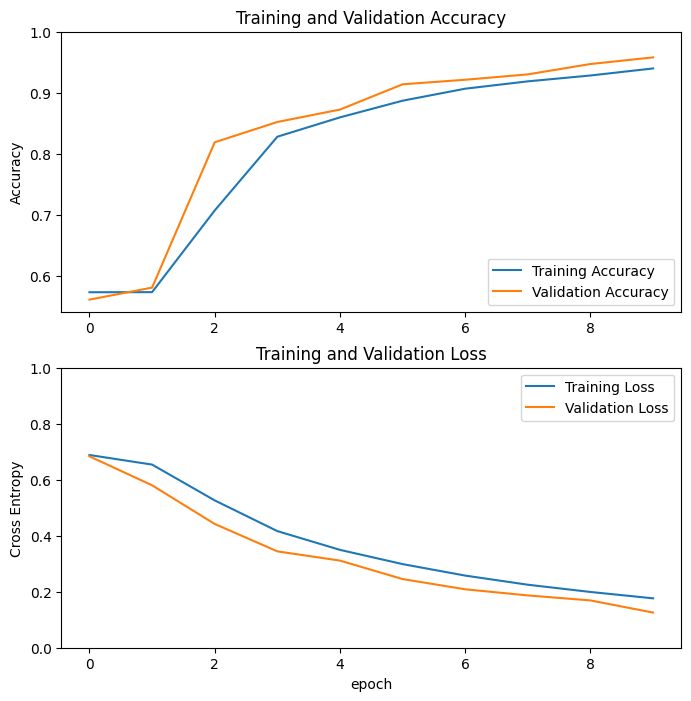

In [26]:
def preview_learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

preview_learning_curve(rnn_history)

The training loss decreases with each epoch and the training accuracy increases with each epoch, the loss and accuracy of validation performs similarly, these are expected behaves.

### Evaluate the sota model

#### Preview learning curve



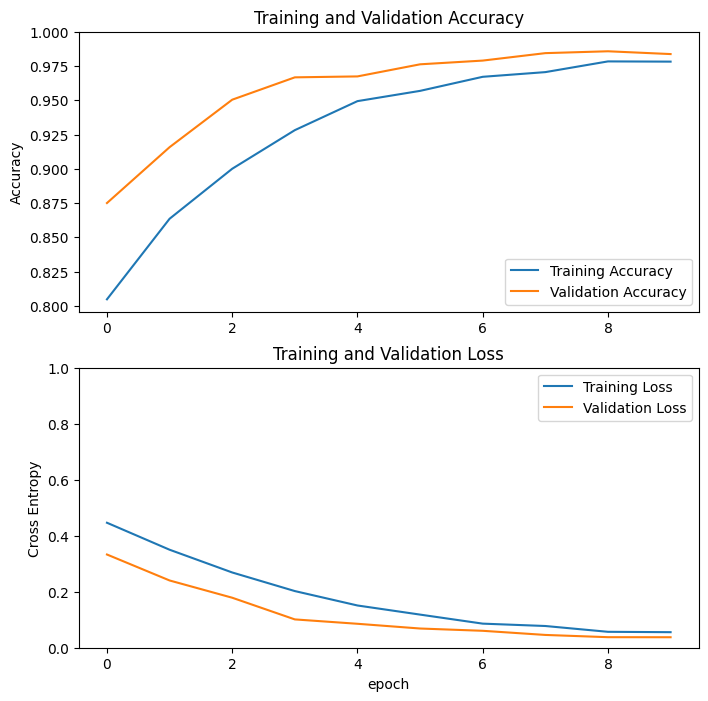

In [27]:
preview_learning_curve(nlp_history)

The training & validation loss decreases with each epoch and the training & validation accuracy increases with each epoch, compare with the baseline model, the nlp model achieves higher accuracy, lower loss, which reflects its more advanced strength. We'll select this model to make the prediction.

### Submission

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The `submission.csv` file uses the following format:
`id,target`

#### Prepare the Test Dataset

In [28]:
raw_test_ds = tf.data.experimental.make_csv_dataset(
    TESTING_FILE_PATH,
    select_columns=['id','text'],
    batch_size=BATCH_SIZE,
    num_epochs=1, # Ensure go through the data once to create a finite dataset
    shuffle=False, # No shuffle for testing data
    prefetch_buffer_size=tf.data.AUTOTUNE,
    num_rows_for_inference=test_num_rows # Help tf optimize the dataset creation
)

In [29]:
test_ds = raw_test_ds.map(lambda batch: batch['text'])

#### Make prediction

Predict by RNN model

In [30]:
# Comment out to speed up notebook execution
# rnn_predictions = model.predict(test_ds)
# rnn_predictions

Predict by NLP model

In [31]:
nlp_predictions = classifier.predict(test_ds)
nlp_predictions

51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 311ms/step


array([[-3.0553315,  3.5645854],
       [-3.6347983,  4.2849135],
       [-3.429138 ,  4.0620484],
       ...,
       [-3.5807745,  4.344046 ],
       [-3.2030237,  3.6618538],
       [-3.5187895,  4.0942917]], dtype=float32)

#### Convert predictions to labels

For the rnn model prediction, the results have single column array, and if prediction >= 0.0, the label is 1 else it's 0.

In [32]:
# Comment out to speed up
# This line used for convert rnn model predictions
# rnn_labels = np.where(predictions >= 0, 1, 0)
# rnn_labels

For the nlp model prediction, the results have two columns, for each row, if the first column value is larger, the label is 0, else it's 1.

In [33]:
nlp_labels = np.argmax(nlp_predictions, axis=1)
nlp_labels

array([1, 1, 1, ..., 1, 1, 1])

#### Save submission

In [34]:
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [35]:
# This line
submission['target'] = nlp_labels

In [36]:
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [37]:
submission.to_csv("submission.csv", index=False)

## Conclusion

Based on the experimental results, DistilBERT (Transformer) consistently demonstrated superior performance compared to the RNN model in the disaster tweet classification task.

The superior performance of DistilBERT can be attributed to its pre-trained nature and ability to capture complex language patterns. DistilBERT was pre-trained on a massive amount of text data, allowing it to learn contextual relationships between words and phrases. This pre-training enables DistilBERT to extract meaningful features from disaster tweets, leading to more accurate classifications.

In conclusion, DistilBERT is a promising approach for disaster tweet classification tasks. Its ability to achieve higher accuracy and lower loss, despite the increased training time, makes it a valuable tool for natural language processing applications in crisis management and information retrieval.


## Reference

- [Recurrent neural network](https://aws.amazon.com/what-is/recurrent-neural-network)
- [Google: Text Classification Guide](https://developers.google.com/machine-learning/guides/text-classification)
- [Tensorflow: Working with RNNs](https://www.tensorflow.org/guide/keras/working_with_rnns)
- [Tensorflow: Text classification with an RNN](https://www.tensorflow.org/text/tutorials/text_classification_rnn)
- [Tensorflow: Compute Similarity Metrics](https://www.tensorflow.org/text/tutorials/text_similarity)
- [Tensorflow: Basic text classification with Keras](https://www.tensorflow.org/tutorials/keras/text_classification)
- [Tensorflow: Classify text with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)
- [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter (NeurIPS 2019)](https://arxiv.org/abs/1910.01108)